In [65]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import keras.backend as K
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
import datetime

from collections import deque
from time import time
from multiprocessing import cpu_count

from keras.utils import Sequence, plot_model, print_summary
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Add, Reshape, Softmax, Input
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
np.random.seed(32)

### Functions

In [3]:
def get_labels(label_path, image_path):
    label_names = os.listdir(label_path)
    label_names = [label_name.split("_")[0] for label_name in label_names]
    image_names = os.listdir(image_path)
    image_names = [image_name.split(".")[0] for image_name in image_names]
    labels = set.intersection(set(label_names), set(image_names))
    labels = list(labels)
    return labels

#### Generators

In [4]:
class SemanticDataGenerator(Sequence):
    #'Generates data for Keras'
    def __init__(self, dataset_image_path=None, dataset_mask_path=None, batch_size=32, dim=None, shuffle=True):
        #'Initialization'
        if dim is not None:
            assert(len(dim)==2), "Need a tuple of height, width"
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset_image_path, self.dataset_mask_path = dataset_image_path, dataset_mask_path
        self.__prepare_file_list()
        self.on_epoch_end()
        
    def __prepare_file_list(self):
        self.file_list = glob.glob1(self.dataset_image_path, "*.png")
        self.id2file = dict(((i, file) for i, file in enumerate(self.file_list)))

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index=None):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.id2file[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp=None):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = deque(maxlen=self.batch_size)
        Y = deque(maxlen=self.batch_size)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x = cv2.imread(os.path.join(self.dataset_image_path, ID))[:, :, ::-1]
            if self.dim is not None:
                x = cv2.resize(x, self.dim)
            X.append(x)

            # Store class
            y = cv2.imread(os.path.join(self.dataset_mask_path, ID), 0)
            if self.dim is not None:
                y = cv2.resize(y, self.dim)
            y = (y == 7).astype(int)
            Y.append(y)

        return np.array(X), np.array(Y)

In [5]:
class BddDataGenerator(SemanticDataGenerator):
    #'Generates data for Keras'
    def __init__(self, dataset_image_path=None, dataset_mask_path=None, batch_size=32, dim=None, shuffle=True, file_ids=None, crop_dx=80):
        #'Initialization'
        super(BddDataGenerator, self).__init__(dataset_image_path=dataset_image_path, dataset_mask_path=dataset_mask_path, batch_size=batch_size, dim=dim, shuffle=shuffle)
        self.__prepare_file_list(file_ids=file_ids)
        self.crop_dx = crop_dx
        super(BddDataGenerator, self).on_epoch_end()
        
    def __prepare_file_list(self, file_ids=None):
        if file_ids is not None:
            self.file_list = file_ids
            self.id2file = dict(((i, file) for i, file in enumerate(self.file_list)))
            
    def __getitem__(self, index=None):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.id2file[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = deque(maxlen=self.batch_size)
        Y = deque(maxlen=self.batch_size)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            x = cv2.imread(os.path.join(self.dataset_image_path, ID + ".jpg"))[:-self.crop_dx, :, ::-1]
            if self.dim is not None:
                x = cv2.resize(x, (self.dim[1], self.dim[0]))
            X.append(x/255.)

            # Store class
            y = cv2.imread(os.path.join(self.dataset_mask_path, ID + "_drivable_id.png"))[:-self.crop_dx]
            y = cv2.cvtColor(y, cv2.COLOR_BGR2GRAY)
            if self.dim is not None:
                y = cv2.resize(y, (self.dim[1], self.dim[0]))
            y = np.logical_or(y == 1, y == 2).astype(int)
            y = to_categorical(y, 2)
#             y = np.reshape(y, (-1, 2))
            Y.append(y)

        return np.array(X), np.array(Y)

In [6]:
def _fire_conv(input_tensor, sq_filters, ex_filters, name="fire"):
    sq1x1 = Conv2D(sq_filters, (1, 1), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/sq1x1")(input_tensor)
    ex1x1 = Conv2D(ex_filters, (1, 1), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/ex1x1")(sq1x1)
    ex3x3 = Conv2D(ex_filters, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/ex3x3")(sq1x1)
    x = Concatenate(axis=3, name=name)([ex1x1, ex3x3])
    return x

In [7]:
def _fire_deconv(input_tensor, sq_filters, ex_filters, name="fire_deconv", upsampling_factors=[2, 2]):
    sq1x1 = Conv2D(sq_filters, (1, 1), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/sq1x1")(input_tensor)
    upsample = UpSampling2D(size=upsampling_factors, data_format="channels_last", interpolation="nearest")(sq1x1)
    upsample = Conv2D(sq_filters, (3, 3), padding="same", activation="relu", name=name+"/upsample_conv")(upsample)
    ex1x1 = Conv2D(ex_filters, (1, 1), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/ex1x1")(upsample)
    ex3x3 = Conv2D(ex_filters, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_uniform", name=name+"/ex3x3")(upsample)
    x = Concatenate(axis=3, name=name)([ex1x1, ex3x3])
    return x

In [8]:
def get_model(input_shape=None, nb_classes=2, show_summary=True, plot=True):
    inp = Input(shape=input_shape, name="input")
    conv1 = Conv2D(64, (3, 3), strides=2, padding="same", activation="relu", kernel_initializer="glorot_uniform", name="conv1")(inp)
    conv1_skip = Conv2D(64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer="glorot_uniform", name="conv1_skip")(inp)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same", name="pool1")(conv1)
    
    fire2 = _fire_conv(input_tensor=pool1, sq_filters=16, ex_filters=64, name="fire2")
    fire3 = _fire_conv(input_tensor=fire2, sq_filters=16, ex_filters=64, name="fire3")
    pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same", name="pool3")(fire3)
    
    fire4 = _fire_conv(input_tensor=pool3, sq_filters=32, ex_filters=128, name="fire4")
    fire5 = _fire_conv(input_tensor=fire4, sq_filters=32, ex_filters=128, name="fire5")
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same", name="pool5")(fire5)
    
    fire6 = _fire_conv(input_tensor=pool5, sq_filters=48, ex_filters=192, name="fire6")
    fire7 = _fire_conv(input_tensor=fire6, sq_filters=48, ex_filters=192, name="fire7")
    fire8 = _fire_conv(input_tensor=fire7, sq_filters=64, ex_filters=256, name="fire8")
    fire9 = _fire_conv(input_tensor=fire8, sq_filters=64, ex_filters=256, name="fire9")
    
    # decoder
    fire10 = _fire_deconv(input_tensor=fire9, sq_filters=64, ex_filters=128, name="fire10")
    fire10_fuse = Add(name="fire10_fuse")([fire10, fire5])
    
    fire11 = _fire_deconv(input_tensor=fire10_fuse, sq_filters=32, ex_filters=64, name="fire11")
    fire11_fuse = Add(name="fire11_fuse")([fire11, fire3])
    
    fire12 = _fire_deconv(input_tensor=fire11_fuse, sq_filters=16, ex_filters=32, name="fire12")
    fire12_fuse = Add(name="fire12_fuse")([fire12, conv1])
    
    fire13 = _fire_deconv(input_tensor=fire12_fuse, sq_filters=16, ex_filters=32, name="fire13")
    fire13_fuse = Add(name="fire13_fuse")([fire13, conv1_skip])
    
    drop13 = Dropout(rate=0.5, name="dropout13")(fire13_fuse)
    conv14 = Conv2D(nb_classes, (1, 1), strides=(1, 1), activation="relu", kernel_initializer="glorot_uniform", name="conv14")(drop13)
#     reshape15 = Reshape(target_shape=(input_shape[0]*input_shape[1], nb_classes), name="reshape15")(conv14)
#     op = Softmax(axis=-1, name="output")(reshape15)
    op = Softmax(axis=-1, name="output")(conv14)
    
    model = Model(inputs=inp, outputs=op, name="squeeze_seg")
    
    if show_summary:
        print_summary(model)
        
    if plot:
        plot_model(model, show_shapes=True)
    
    return model

In [9]:
def setup_callbacks(directory, config_id="1"):
    logdir = os.path.join(directory, "logs", config_id)
    ckpt = os.path.join(directory, "ckpt", config_id)
    os.makedirs(ckpt)
    ckpt_file = os.path.join(ckpt, "model.h5")
    callbacks = []
    callbacks.append(EarlyStopping(patience=10, verbose=2, restore_best_weights=True))
    callbacks.append(TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=True, write_images=True))
    callbacks.append(ModelCheckpoint(filepath=ckpt_file))
    callbacks.append(ReduceLROnPlateau(patience=5))
    return callbacks

In [10]:
def split_labels(label_ids, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + test_ratio + test_ratio == 1.0, "Ratio  needs to equal 1.0"
    label_ids = np.array(label_ids)
    np.random.shuffle(label_ids)
    length = label_ids.shape[0]
    train_ids = label_ids[:int(length*train_ratio)]
    val_ids = label_ids[int(length*train_ratio):int(length*(train_ratio + val_ratio))]
    test_ids = label_ids[int(length*(train_ratio + val_ratio)):]
    
    return train_ids, val_ids, test_ids

### Script

In [11]:
root_path = "/home/ankurrc/files/usl/drivable_area"
dataset_path = os.path.join(root_path, "bdd_custom")
experiments_path = os.path.join(root_path, "experiments")
image_path = os.path.join(dataset_path, "images")
label_path = os.path.join(dataset_path, "labels")

In [12]:
dims = (240, 480)
input_shape = (240, 480, 3)
batch_size=16
epochs=300

In [13]:
label_ids = get_labels(image_path=image_path, label_path=label_path)
train_ids, val_ids, test_ids = split_labels(label_ids, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1)

In [14]:
# takes ~3m38s on 12 worker threads for batch_size=4
train_gen = BddDataGenerator(dataset_image_path=image_path, dataset_mask_path=label_path, dim=dims, batch_size=batch_size, shuffle=True, file_ids=train_ids)
val_gen = BddDataGenerator(dataset_image_path=image_path, dataset_mask_path=label_path, dim=dims, batch_size=batch_size, shuffle=True, file_ids=val_ids)
test_gen = BddDataGenerator(dataset_image_path=image_path, dataset_mask_path=label_path, dim=dims, batch_size=batch_size, shuffle=True, file_ids=test_ids)

In [15]:
K.clear_session()
timestamp = str(time())
current_experiment_dir = datetime.datetime.fromtimestamp(int(timestamp.split(".")[0])).strftime('%Y_%m_%d-%H_%M_%S')
current_experiment_path = os.path.join(experiments_path, current_experiment_dir)
callbacks = setup_callbacks(current_experiment_path)

model = get_model(input_shape=input_shape, show_summary=False, plot=True)
model.compile(Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit_generator(generator=train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen, shuffle=True, workers=cpu_count(), verbose=1)

Epoch 1/300
500/500 [==============================] - 308s 617ms/step - loss: 0.2654 - acc: 0.8773 - val_loss: 0.1968 - val_acc: 0.9078
Epoch 2/300
500/500 [==============================] - 296s 591ms/step - loss: 0.1910 - acc: 0.9135 - val_loss: 0.1835 - val_acc: 0.9161
Epoch 3/300
500/500 [==============================] - 295s 590ms/step - loss: 0.1794 - acc: 0.9203 - val_loss: 0.1683 - val_acc: 0.9220
Epoch 4/300
500/500 [==============================] - 291s 583ms/step - loss: 0.1675 - acc: 0.9268 - val_loss: 0.1604 - val_acc: 0.9295
Epoch 5/300
500/500 [==============================] - 284s 568ms/step - loss: 0.1684 - acc: 0.9270 - val_loss: 0.1585 - val_acc: 0.9309
Epoch 6/300
500/500 [==============================] - 281s 562ms/step - loss: 0.1546 - acc: 0.9337 - val_loss: 0.1463 - val_acc: 0.9364
Epoch 7/300
500/500 [==============================] - 280s 560ms/step - loss: 0.1479 - acc: 0.9368 - val_loss: 0.1464 - val_acc: 0.9366
Epoch 8/300
500/500 [====================

In [16]:
model.evaluate_generator(test_gen, workers=cpu_count())

[0.1057600185515419, 0.9582700027573493]

In [17]:
for i in test_gen:
    x, y = i
    break

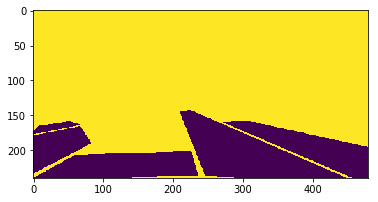

In [19]:

img = y[0]
plt.imshow(img[:, :, 0])

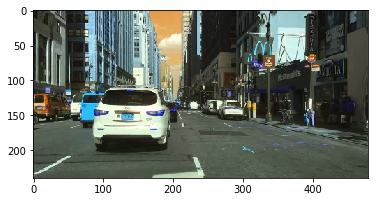

In [18]:
plt.imshow(x[0])

In [20]:
pred = model.predict(x[0][None, :, :, :], batch_size=1)

AttributeError: 'numpy.ndarray' object has no attribute 'autoscale_None'

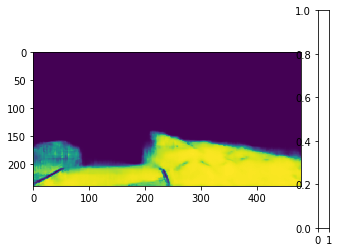

In [25]:
plt.imshow(pred[0, :, :, 1])

In [24]:
pred[0]

array([[[9.9976867e-01, 2.3133743e-04],
        [9.9993670e-01, 6.3313251e-05],
        [9.9999869e-01, 1.3481947e-06],
        ...,
        [1.0000000e+00, 3.2771215e-16],
        [1.0000000e+00, 2.1316841e-11],
        [9.9999917e-01, 7.9525330e-07]],

       [[1.0000000e+00, 1.5487146e-08],
        [1.0000000e+00, 3.7046810e-11],
        [1.0000000e+00, 5.5760628e-15],
        ...,
        [1.0000000e+00, 1.6441615e-30],
        [1.0000000e+00, 5.8092563e-23],
        [1.0000000e+00, 1.1309492e-17]],

       [[1.0000000e+00, 4.5255542e-09],
        [1.0000000e+00, 3.8662110e-13],
        [1.0000000e+00, 1.9673748e-16],
        ...,
        [1.0000000e+00, 3.1580234e-26],
        [1.0000000e+00, 9.3950286e-23],
        [1.0000000e+00, 9.7621509e-19]],

       ...,

       [[7.7341676e-01, 2.2658327e-01],
        [7.4867654e-01, 2.5132346e-01],
        [6.8211597e-01, 3.1788406e-01],
        ...,
        [4.5252051e-02, 9.5474792e-01],
        [4.3261975e-02, 9.5673800e-01],
        [